## what we are going to answer in that section

10. Does the **number of reviews (rating_count)** affect the **average rating**?
    → (*Correlation or regression*)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

from scipy.stats import (
    ttest_1samp, ttest_ind, ttest_rel,
    norm, chi2, f_oneway, chi2_contingency, chisquare
)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/amazon_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

# clean 
df['actual_price'] = (df['actual_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discounted_price'] = (df['discounted_price'].str.replace('₹', '', regex=False).str.replace(',', '', regex=False))
df['discount_percentage'] = (df['discount_percentage'].str.replace('%', '', regex=False).str.replace(',', '', regex=False))
df['rating_count'] = (df['rating_count'].str.replace(',', '', regex=False))
df['rating'] = (df['rating'].str.replace('|', '0', regex=False))


df['actual_price']= df['actual_price'].astype(float)
df['discounted_price']= df['discounted_price'].astype(float)
df['discount_percentage']= df['discount_percentage'].astype(float)
df['rating_count']= df['rating_count'].astype(float)
df['rating']= df['rating'].astype(float)

# turn discount_percentage to float percentage
df['discount_percentage']= df['discount_percentage'].apply(lambda x: x/100)

# make the discounted_price more accurate
df['discounted_price'] = (df['actual_price'] * (1 - df['discount_percentage']))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           1465 non-null   object 
 1   product_name         1465 non-null   object 
 2   category             1465 non-null   object 
 3   discounted_price     1465 non-null   float64
 4   actual_price         1465 non-null   float64
 5   discount_percentage  1465 non-null   float64
 6   rating               1465 non-null   float64
 7   rating_count         1463 non-null   float64
 8   about_product        1465 non-null   object 
 9   user_id              1465 non-null   object 
 10  user_name            1465 non-null   object 
 11  review_id            1465 non-null   object 
 12  review_title         1465 non-null   object 
 13  review_content       1465 non-null   object 
 14  img_link             1465 non-null   object 
 15  product_link         1465 non-null   o

In [4]:
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,395.64,1099.0,0.64,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,198.93,349.0,0.43,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,189.90,1899.0,0.90,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,328.53,699.0,0.53,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,155.61,399.0,0.61,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [5]:
df['category_clean'] = df['category'].apply(lambda x: x.split('|')[-1])
df.sort_values(by= 'category')

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,category_clean
1157,B0912WJ87V,Reffair AX30 [MAX] Portable Air Purifier for C...,Car&Motorbike|CarAccessories|InteriorAccessori...,2320.00,4000.0,0.42,3.8,1118.0,[NEW LAUNCH - INNOVATIVE DESIGN] EFFICIENT PUR...,"AG6W5HESRSDLBX3NCYOOUGFOWERA,AED4U5CF37HVSYPMD...","Arivazhagan,Ajit,swanand pandit,Venkatesh S.,S...","R3TOOFPX256D59,R1PR50BDQOEIIO,R392FI4QWXWOX5,R...","Liked it,User friendly and effective,Not as pe...","As of now its working fine, but don't expect m...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Reffair-AX30-MAX-Interna...,AirPurifiers&Ionizers
695,B097C564GC,"rts [2 Pack] Mini USB C Type C Adapter Plug, T...",Computers&Accessories|Accessories&Peripherals|...,299.94,4999.0,0.94,4.3,4426.0,【WIDER COMPATIBILITY】This USB C Female to USB ...,"AGO5SRT3ESLNL5WTRQFD5BSIYPQA,AGGNODUMRADB3PQQT...","Naga Sai Gadagottu,Neha Sharma,Amazon Customer...","R3CUNCZTU43JPP,RSO46BN8S4OSU,R2UD5D7T4DZRE5,R2...","Tiny helping hand,Good product,As a whole good...",This eliminates the need to buy chargers for t...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/rts-Adapter-Charging-Con...,USBtoUSBAdapters
742,B094DQWV9B,Kanget [2 Pack] Type C Female to USB A Male Ch...,Computers&Accessories|Accessories&Peripherals|...,147.63,399.0,0.63,4.0,1540.0,👍【USB C TO USB ADAPTER】-This is a USB C FEMALE...,"AFA6YM4NTFRGHHKYN5U7HUYEVSUA,AEB3EVUTQCHIE3PGI...","Abhi_K,Amazon Customer,Swap,shivam,Abhinav Sin...","R1QIWMR6C3F3U0,R1MSGOZTOMZE4B,R20OZCEE82GU0W,R...","Good and does it’s work,Nice product working a...",Using it to connect my type C Plantronic headp...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Kanget-Female-Adapter-St...,USBtoUSBAdapters
906,B009LJ2BXA,Hp Wired On Ear Headphones With Mic With 3.5 M...,Computers&Accessories|Accessories&Peripherals|...,649.35,999.0,0.35,3.5,7222.0,Powerful bass and clear treble sounds|Wired co...,"AFIZUD4UBB67LGWY6CVLRHKA75IA,AG2TD3527KNZZNE46...","Deepthi,Nitin Mishra,Raju Chacko,A.VISWANATHAR...","R392ZYXC6D3GY0,R1MJHZXZ09ETAE,R20PJKJTCF9RXN,R...","Headset,Overall a good product. Sound quality ...","Not a perfect fit for long usage,One problem y...",https://m.media-amazon.com/images/I/31eE6slx4E...,https://www.amazon.in/HP-B4B09PA-Headphones-wi...,PCHeadsets
748,B08SCCG9D4,JBL Commercial CSLM20B Auxiliary Omnidirection...,Computers&Accessories|Accessories&Peripherals|...,940.00,2000.0,0.53,3.9,14969.0,Omnidirectional pickup pattern|3.5mm TRRS jack...,"AFROXVCIF6PZXFXLS7DLTPT2CGCQ,AHA4ODJMDNBNUVEUS...","Ansh KaTariA,Saqlain Shaikh,Sardar V.,Rushikes...","R20M6JOASW88SS,RPM4RV2MQNNN0,R19KRP5SDTN2NL,R1...","It's just good !,Good for WFH,Works according ...",It just good for beginners you can start your ...,https://m.media-amazon.com/images/I/41U9-x0JGP...,https://www.amazon.in/JBL-Commercial-Omnidirec...,PCMicrophones
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,B00LOD70SC,Pilot V7 Liquid Ink Roller Ball Pen (2 Blue + ...,OfficeProducts|OfficePaperProducts|Paper|Stati...,178.50,210.0,0.15,4.3,2450.0,Unique 3 dimple tip technology from Japan for ...,"AG3G7G2DUJKN5YMCOYZNCADKKJUQ,AH44B2X6AT45J37MH...","Madhusmita singh,Sandeep Singh,Jay OG,Asim,Vik...","R1AY8EXPHPWDDR,R24503W0UJGTMU,R27P97SD5T4MUX,R...","It's good,Good,One of the few items on amazon ...",Everything is fine but it's bit dark and stick...,https://m.media-amazon.com/images/I/31pJvN8OkS...,https://www.amazon.in/Pilot-Liquid-Roller-Ball...,RetractableBallpointPens
850,B07SBGFDX9,"Pentonic Multicolor Ball Point Pen, Pack of 10",OfficeProducts|OfficePaperProducts|Paper|Stati...,120.00,120.0,0.00,4.1,4308.0,"0.7 mm tip size|Black Body, Multicolor Ink(Bla...","AGK76H5VGHDWFQD7JTHVKZNQ5BHA,AHWXK2FU23OBRZZUA...","Parul S.,Prateek Tiwari,kateriki,golla 

### 10. Does the **number of reviews (rating_count)** affect the **average rating**?
    → (*Correlation or regression*)

In [6]:
df_clean = df[['category_clean', 'rating_count', 'rating']].dropna()


In [7]:
top_categories= df_clean.value_counts('category_clean').head(15).reset_index()
categories= top_categories['category_clean'].to_list()
categories

['USBCables',
 'SmartWatches',
 'Smartphones',
 'SmartTelevisions',
 'In-Ear',
 'RemoteControls',
 'MixerGrinders',
 'Mice',
 'DryIrons',
 'HDMICables',
 'InstantWaterHeaters',
 'LintShavers',
 'ElectricHeaters',
 'FanHeaters',
 'ElectricKettles']

In [8]:
# Filter df_sorted to keep only top categories
df_top15 = df_clean[df_clean['category_clean'].isin(categories)]

Correlation coefficient: 0.10454163231782487
p-value: 0.00436239441164251


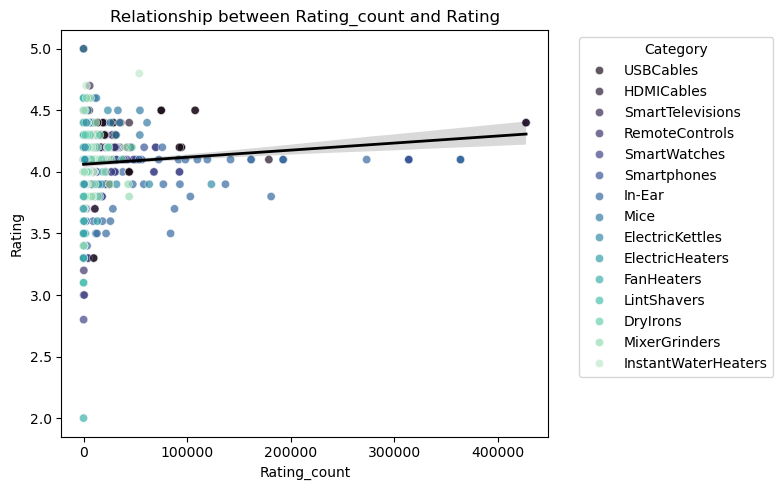

In [9]:
from scipy.stats import pearsonr

r, p = pearsonr(df_top15['rating_count'], df_top15['rating'])
print("Correlation coefficient:", r)
print("p-value:", p)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_top15, x='rating_count', y='rating', hue='category_clean', alpha=0.7, palette='mako')
sns.regplot(data=df_top15, x='rating_count', y='rating', scatter=False, color='black', line_kws={'linewidth':2})
plt.title('Relationship between Rating_count and Rating')
plt.xlabel('Rating_count')
plt.ylabel('Rating')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()